In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import  roc_curve, auc, precision_recall_curve



In [132]:
df = pd.read_csv("ADASYN training_dataset.csv")


In [133]:
df = df.drop(columns=["Unnamed: 0", "DATE"], errors="ignore")

In [134]:
imputer = SimpleImputer(strategy="mean")
df[df.columns] = imputer.fit_transform(df)

In [135]:
df['Ava_date'].value_counts()

Ava_date
0.0    4227
1.0    4113
Name: count, dtype: int64

In [136]:
df_test = pd.read_csv("test_set.csv")

In [137]:
df_test = df_test.drop(columns=["Unnamed: 0", "DATE"], errors="ignore")

In [138]:
imputer = SimpleImputer(strategy="mean")
df_test[df_test.columns] = imputer.fit_transform(df_test)

In [139]:
df_test['Ava_date'].value_counts()

Ava_date
0.0    846
1.0    250
Name: count, dtype: int64

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8340 entries, 0 to 8339
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Maximum_humidity_              8340 non-null   float64
 1   Average_humidity_              8340 non-null   float64
 2   Minimum_humidity_              8340 non-null   float64
 3   Precipitation_mm               8340 non-null   float64
 4   Average_temperature_C          8340 non-null   float64
 5   Maximum_temperature_C          8340 non-null   float64
 6   Minimum_temperature_C          8340 non-null   float64
 7   Heating_Degree_Days_Base_20_C  8340 non-null   float64
 8   Heating_Degree_Days_base_18_C  8340 non-null   float64
 9   Cooling_Degree_Days_Base_21_C  8340 non-null   float64
 10  Average_speed_ms               8340 non-null   float64
 11  Gust_speed_ms                  8340 non-null   float64
 12  Stay_time_min                  8340 non-null   f

In [141]:
X_train = df[['Maximum_humidity_', 'Average_humidity_', 'Minimum_humidity_',
       'Precipitation_mm', 'Average_temperature_C', 'Maximum_temperature_C',
       'Minimum_temperature_C',
       'Average_speed_ms', 'Gust_speed_ms', 'Stay_time_min',
       'Calm_duration_min']]
y = df['Ava_date']

In [142]:
X_test = df_test[['Maximum_humidity_', 'Average_humidity_', 'Minimum_humidity_',
       'Precipitation_mm', 'Average_temperature_C', 'Maximum_temperature_C',
       'Minimum_temperature_C',
       'Average_speed_ms', 'Gust_speed_ms', 'Stay_time_min',
       'Calm_duration_min']]
y_test = df_test['Ava_date']

In [143]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [144]:
# Get best parameters
best_params = {
    'n_estimators': 500,       
    'max_depth': 12,          
    'min_samples_split':10,
    'criterion': 'gini',
    'min_samples_leaf': 2,
    'bootstrap': False,

    }

# Train Model
rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(X_train, y)



RandomForestClassifier(bootstrap=False, max_depth=12, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500, random_state=42)

In [159]:
# Get predicted probabilities for class 1
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Define threshold range
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores_class1 = []

# Evaluate F1-score for each threshold
for t in thresholds:
    y_pred = (y_prob > t).astype(int)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores_class1.append(f1)

# Automatically find threshold that maximizes F1 for class 1
best_index = np.argmax(f1_scores_class1)
best_threshold = thresholds[best_index]
best_threshold = best_threshold -0.05

# Use the best threshold to make final predictions
y_pred_adj = (y_prob > best_threshold).astype(int)

print(f"Best threshold for optimizing F1-score of class 1: {best_threshold:.3f}")

Best threshold for optimizing F1-score of class 1: 0.664


In [160]:
# Final Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_adj))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       846
         1.0       0.86      0.92      0.89       250

    accuracy                           0.95      1096
   macro avg       0.92      0.94      0.93      1096
weighted avg       0.95      0.95      0.95      1096



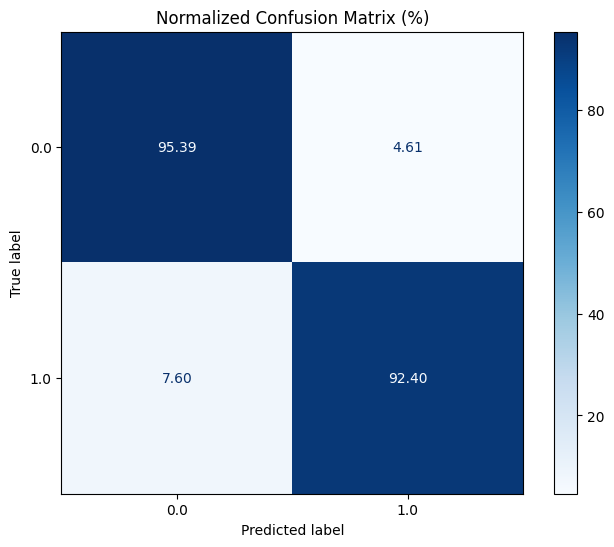

In [161]:
cm = confusion_matrix(y_test,y_pred_adj)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=rf_model.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, values_format=".2f") 

plt.title("Normalized Confusion Matrix (%)")
plt.show()

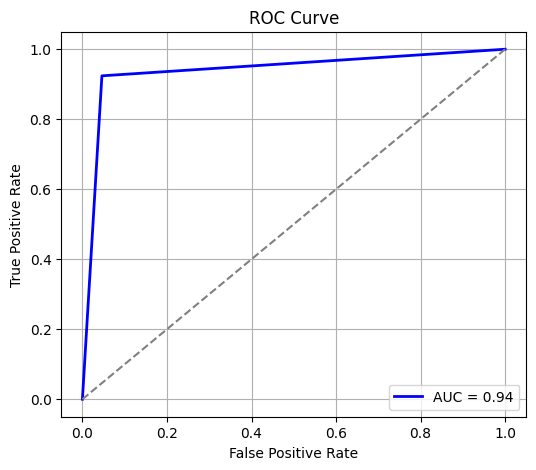

In [148]:
cm = confusion_matrix(y_test, y_pred_adj)
fpr, tpr, _ = roc_curve(y_test, y_pred_adj)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

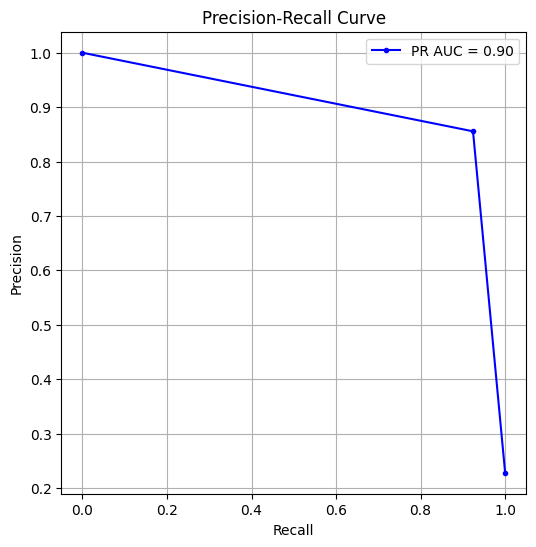

In [149]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_adj)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()